In [81]:
import cv2
import numpy as np
import pims
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import find_peaks
import peakutils

def collect(x, y, sigma):
    neighborhood = []
    X = int(sigma)
    for i in range(-X, X + 1):
        Y = int(pow(sigma * sigma - i * i, 1 / 2))
        for j in range(-Y, Y + 1):
            neighborhood.append((x + i, y + j))
    return neighborhood


def load_image(path):
    frames = pims.ImageSequence(path, as_grey=True)
    return frames


def sum_normalise_image(frames):
    image= np.float64(frames[0])
    frame_size = len(frames)
    for frameNum in range(1, frame_size-1):
        image = np.sum([image,np.int64(frames[frameNum])],axis=0)
    image = np.array((image/image.max()) * 255, dtype = np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    shifted = cv2.pyrMeanShiftFiltering(image, 2, 2)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    plt.imshow(imagesum)
    return gray


def threshold_image(gray, peak_min_distance):
    # convert the mean shift image to grayscale, then apply
    # Otsu's thresholding
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # compute the exact Euclidean distance from every binary
    # pixel to the nearest zero pixel, then find peaks in this
    # distance map
    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, indices=False, min_distance=peak_min_distance, labels=thresh)
    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then appy the Watershed algorithm
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh)
    print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
    return labels


def get_labels(labels, total_frames, gray, bound_lower, bound_upper):
    z = 0;
    noParticles = len(np.unique(labels))
    particle_index = np.linspace(0, noParticles - 1, noParticles, dtype='int')
    particle_coords = [0] * total_frames
    particle_roi_dict = dict(zip(particle_index, particle_coords))
    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label != 0:
            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(gray.shape, dtype="uint8")
            mask[labels == label] = 255
            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)[-2]
            c = max(cnts, key=cv2.contourArea)
            # draw a circle enclosing the object
            ((x, y), r) = cv2.minEnclosingCircle(c)
            if r > bound_lower:
                if r < bound_upper:
                    particle_roi_dict[z] = collect(int(x), int(y), int(r))
                    z = z + 1
    return particle_roi_dict
    # cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    # Visualising the ROIs
    # cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    # cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
    # cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)


def orangise_dict(particle_roi_dict, frames):
    total_frames = len(frames)
    frame_index = np.linspace(0, total_frames - 1, total_frames, dtype='int')
    frame_intensity = [0] * total_frames
    overall_dict = dict(zip(frame_index, frame_intensity))
    for key1, value1 in enumerate(frames):  # key1: frame number, value1: frame info
        current_particle_intensity = 0
        particle_dict = dict()
        for key0, value0 in enumerate(particle_roi_dict):  # Key0: particle number
            a = np.asarray(particle_roi_dict[key0])
            try:
                particle_dict[key0] = np.sum(value1[a[:, 0], a[:, 1]])
            except:
                print(key0)
                break
        overall_dict[key1] = particle_dict
    return overall_dict


def organise_dict_frame(particle_dict):
    new_new_overall_dict = dict()
    for key0 in range(0, len(particle_dict.keys())):  # frames
        new_new_overall_dict[key0] = sum(particle_dict[key0].values())
    return new_new_overall_dict


def unknowndict(overall_dict):
    new_overall_dict = dict()
    for key0 in range(0, len(overall_dict[0])):  # key1: particle number
        new_current_particle = dict()
        for key1 in range(0, len(overall_dict)):  # key1: frame number
            new_current_particle[key1] = overall_dict[key1][key0]
        new_overall_dict[key0] = new_current_particle
    return new_overall_dict

[INFO] 1803 unique segments found


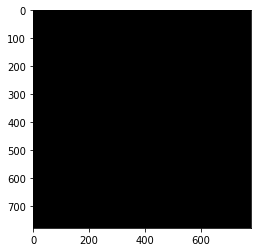

In [83]:
# Image Loading
str1 = 'images/'
date = '25_03_19'
name = 'Cd_dots and gCAMP_dish2'
other = '/mov1/ch00/'# non_normalised for dots, dyeChannel for dyes
extension = '*.tif'
path = str1+date+'/'+name+other+extension

other2 = '/mov1/ch02/'# non_normalised for dots, dyeChannel for dyes
path2 = str1+date+'/'+name+other2+extension

dot_frames = load_image(path)
dye_frames = load_image(path)

frame_number = len(dye_frames)

gray = sum_normalise_image(dye_frames)
labels = threshold_image(gray, 20)

particle_roi_dict = get_labels(labels, frame_number, gray, 5, 20)
overall_dict_byparticle = orangise_dict(particle_roi_dict, dot_frames)
overall_dict_byframe = organise_dict_frame(overall_dict_byparticle)

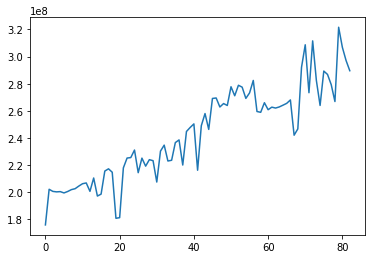

In [84]:
plt.plot(overall_dict_byframe.keys(),overall_dict_byframe.values())

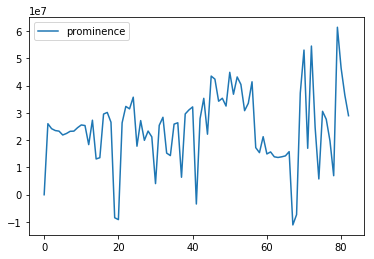

array([ 1,  4, 11, 13, 17, 24, 26, 28, 32, 36, 40, 43, 46, 48, 50, 52, 56,
       59, 61, 66, 70, 72, 75, 79])

In [85]:
dot_values = np.array(overall_dict_byframe.values())

peaks, _ = find_peaks(dot_values, prominence=1)

dot_values_cut = np.subtract(dot_values,peakutils.baseline(dot_values))

#plt.plot(peaks, dot_values_cut[peaks], ".b"); 
plt.plot(dot_values_cut); 
plt.legend(['prominence'])
plt.show()
peaks